# Use third party language models with ArcGIS

## Introduction

The Text Analysis toolset in the GeoAI toolbox provides a set of tools for text processing tasks, such as text classification, entity extraction, and text translation. The natural language processing (NLP) models that are created using these tools are built on language models such as BERT, RoBERTa, and T5, and large language models (LLMs), such as Mistral, to ensure high-performance text analysis.

While these prebuilt models are robust, you may need a custom NLP workflow, such as when using an LLM for standardizing addresses, performing sentiment analysis, or extracting custom entities or relationships not currently supported by the Text Analysis toolset. 

To meet these needs, you can integrate ArcGIS with external third-party language models. This includes open source LLMs as well as cloud-hosted, commercial LLMs accessed using a web API. Keep in mind that if you are using a web hosted LLM, the data that you are processing will be sent to the LLM provider for processing. Python developers can author a custom NLP function to integrate with external models and package their model as an Esri deep learning package (.dlpk file) for use with the following tools:

1. [Classify Text Using Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/classify-text-using-deep-learning.htm)
2. [Extract Entities Using Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/extract-entities-using-deep-learning.htm)
3. [Transform Text Using Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/transform-text-using-deep-learning.htm)


By following the steps outlined in this documentation, you will be able to create and use custom .dlpk files effectively, enhancing your text analysis tasks with models tailored to your needs.

## Custom Python NLP Function

You can create an NLP function in Python to integrate third-party language models into a text processing pipeline. NLP functions handle text data and perform various text processing tasks.

### Anatomy of a Python NLP Function

#### `__init__`

The `__init__` method initialize instance variables such as name, description, and other attributes essential for the NLP function.

#### `initialize`

The `initialize` method is used to load the NLP model and set up any initial configurations. Use this method at the start of the Python NLP function.

#### `getParameterInfo`

The `getParameterInfo` method specifies the parameters that the NLP function accepts. This includes any configuration settings required to load or connect to the model as well as parameters needed for text processing.

#### `getConfiguration`

The `getConfiguration` method describe how the function will perform input processing and generate outputs. It includes details for any preprocessing or postprocessing steps necessary for the function.

#### `predict`

The `predict` method responsible for converting input text to the desired output. It uses defined parameters and processing logic to produce the final result.


### In-Depth Method Overview


#### `__init__`

The `__init__` method is the constructor of the custom NLP function and initializes instance variables such as the name, description, and other essential attributes. This method sets the properties that will define the behavior and characteristics of the NLP function.

The constructor creates an instance of a custom NLP class with all the attributes required for processing and analysis. When creating an instance of an NLP class, this method ensures that it has the required settings and default values. For example, if the NLP function needs specific settings such as paths to models, or special tokens, they can be set up in this method.


```python
class MyTextClassifier:
    def __init__(self, **kwargs):
        """
        It sets up the initial state of an object by defining its attributes,
        such as name, description, and other properties.

        """
        self.name = "Text classifier"
        self.description = '''The `MyTextClassifier` class is designed to perform text classification tasks
                            such as categorizing text data into predefined categories.'''
        # Additional initialization code here
        ...


#### `initialize`

The initialize method is called at the start of the custom Python NLP function and to this method, the kwargs['model'] is passed. The kwargs['model'] argument is the path to the Esri model definition file (.emd). The method should be used to load the model weights to set up the NLP model, ensuring a reference to it for subsequent operations.

```python
def initialize(self, **kwargs):
    """
    Initialize model parameters, such as loading pretrained model weights.
    """
    json_file = kwargs['model']
    with open(json_file, 'r') as f:
        self.json_info = json.load(f)
    
    # access the model path in the model definition file
    model_path = json_info['ModelFile']
    # load your model and keep an instance for the model
    self.model = load_your_model(model_path)
    
    # Additional initialization code here
    ...
```

#### `getParameterInfo`

The getParameterInfo method is called by the Text Analysis tools after the initialize method and is where the parameters needed by the model are defined. This method returns a list of input parameters expected by the custom NLP function. Each parameter is described using a dictionary containing the name, data type, display name, and description of the parameter, and a Boolean parameter indicating whether the parameter is required, as shown below.

```python
def getParameterInfo(self):
    return [
        {
            "name": "class_names",
            "dataType": "string",
            "required": True,
            "displayName": "class_names",
            "description": "Comma-separated list of class names used for classification.",
            "value": "positive,negative"
        },
        {
            "name": "prompt",
            "dataType": "string",
            "required": False,
            "displayName": "prompt",
            "description": "The number of samples processed in one forward pass through the model.",
            "value": "Classify the following text into the defined classes."
        },
        # Additional code here
        ...
    ]
    
```

**Returns**: The method returns a list of dictionaries, each describing a parameter.

Key attributes of the dictionary are as follows:

- **`name`**: A string identifier for the parameter
- **`dataType`**: The type of data the parameter accepts, such as a `string`, `Boolean`, or `list`
- **`value`**: The default value for the parameter
- **`required`**: A Boolean indicating whether the parameter is required
- **`displayName`**: A user-friendly name for the parameter
- **`domain`**: A set of allowed values, if applicable
- **`description`**: A detailed description of the parameter

The list of parameters is displayed to the user through the custom model's model arguments in the Text Analysis tools. Users of the model can set these values interactively using the tool user interface or programmatically pass them into the getConfiguration method as keyword arguments.

#### `getConfiguration`

The `getConfiguration` method sets up and manages the parameters for the NLP function. It is passed keyword arguments containing the parameters updated by users of the model through the tool or provided programmatically. The method also controls how the function processes and outputs data based on the updated parameters. This method is invoked after the getParameterInfo method but before the predict method. The return value of the function is a dictionary containing value of the `batch_size` indicating how many strings the model can process at a time. The return value of the method informs the tool how the input data needs to be split for processing by the model one batch at a time.


```python
def getConfiguration(self, **kwargs):
    """
    This method configures the supported NLP function parameters and
    controls further processing based on them.
    """
    # Set the class names from the provided arguments
    self.class_names = kwargs.get("class_names", "")
    self.prompt = kwargs.get("prompt", "")
    # Set the batch size, limiting it to a maximum of 4
    if kwargs.get("batch_size", 0) > 4:
        kwargs["batch_size"] = 4
       
    # Additional code here
    ...
    
    # Return the updated parameter values
    return kwargs
```

In the example above, the custom NLP function is configured by doing the following:

- Setting the `class_names` parameter from the provided arguments.
- Setting the `prompt` parameter from the provided arguments.
- Limiting the `batch_size` parameter to a maximum of 4 if a larger value is provided.
- Returning the updated parameter values.

#### `predict`

The `predict` method performs inference, that is, it generates predictions with the NLP model. This method is passed a FeatureSet containing the input features (or rows in the case of a table) and kwargs containing the field name which contains the input strings. This method returns the results in the form of a FeatureSet object. The following is a typical workflow:

- Extract the input text to be processed from the provided FeatureSet and preprocess it to match the model’s requirements.
- Apply the NLP model to the preprocessed text to generate predictions.
- Refine or format the model’s predictions as needed.
- Package the processed predictions into a FeatureSet object and return it.


```python
def predict(self, feature_set: FeatureSet, **kwargs):
    """
    Predicts the classification of text data from the input FeatureSet and returns a new FeatureSet with the predictions.
    """
    # read the text from the input Featureset, when calling this function from ArcGIS Pro tools, be sure to use the name of the column that contains the text data instead of `input_str`.
    field = kwargs["input_field"]
    input_text = feature_set.df[field].to_list() 
    # Preprocessing input code here
    # 
    ... 
    
    # Make Predictions
    results = self.model.predict(input_text, self.class_names, self.prompt)
    
    # Additional code here
    ... 
    
    # Create featureset
    feature_dict = {
        "fields": [
            {"name": "input_str", "type": "esriFieldTypeString"},
            {"name": "class", "type": "esriFieldTypeString"}
        ],
        'geometryType': "",
        'features': [{'attributes': {'input_str': inputs, "class": result}}]
    }
    
    # Return the featureset
    return FeatureSet.from_dict(feature_dict)
```

## Esri Model Definition (.emd) File

After creating a custom Python NLP function, include a reference to the function in the `.emd` file by specifying it next to the InferenceFunction parameter. This ensures that the `.emd` file correctly links to the function, enabling it to be used in an NLP processing pipeline.

```json
{
    "InferenceFunction": "MyTextClassifier.py",
    "ModelType": "TextClassifier",
    "OutputField": "ClassLabel",
    "Labels": [
        "positive",
        "negative"
    ],


    # additional keys here
    ...
}
```

Note:
The .emd file must include the following keys:

- InferenceFunction — Specify the name of the file containing the custom NLP function.
- ModelType — Indicate the type of model based on its task. Supported values are TextClassifier, SequenceToSequence, and EntityRecognizer.
- OutputField — Provide the name of the output field that will store the results for TextClassifier or SequenceToSequence models.

## Custom Deep Learning Package (.dlpk) Model File

To complete a custom NLP setup, create a .dlpk model file. The .dlpk file allows you to use a model with the with the `arcgis.learn` Python API and the inference tools in the Text Analysis toolset.

Organize the files as follows:

1. **Create a Folder:** Create a folder and include the custom NLP function file (for example, MyTextClassifier.py) and the Esri .emd file (for example, TextClassifier.emd). The name of the folder must match the name of the .emd file.
   Example folder structure:

```
TextClassifier/
├── MyTextClassifier.py
└── TextClassifier.emd
```

Include any additional files or folders as necessary for the NLP function.

2. **Zip the Folder:** Compress the folder into a ZIP archive. Rename the .zip file to match the name of the .emd file but with the .dlpk extension. Example final file name:

```
TextClassifier.dlpk
```


This `.dlpk` file is now ready for use with the `arcgis.learn` Python API and can be incorporated into the text analysis tools inside `ArcGIS Pro`.


## Using the Custom .dlpk with the arcgis.learn API

The `arcgis.learn` Python API supports for third party custom models through various classes, including `TextClassifier`, `EntityRecognizer`, and `SequenceToSequence`. To utilize your custom `.dlpk` file for inference with these classes, follow the steps below. The example provided demonstrates how to use the `TextClassifier` class, but you can apply similar steps for the other supported classes.

### Example with TextClassifier

```python
from arcgis.learn.text import TextClassifier

model = TextClassifier.from_model(
"path_to_your_custom_dlpk_file"
)

results = model.predict("Input String or list")

results_df = results.df
```


1. **Import the TextClassifier Class:**
   Begin by importing the `TextClassifier` class from the `arcgis.learn.text` module.
   
   

2. **Load the Custom Model:**
   Use the `from_model` method to load your custom `.dlpk` file. Replace `"path_to_your_custom_dlpk_file"` with the actual path to your `.dlpk` file. You can also define additional keyword arguments as needed.




3. **Perform Inference:**
Use the predict method of the TextClassifier class to make predictions. You can pass a single input string or a list of strings.

4. **Extract Results:**
Convert the results to a DataFrame and extract the information as needed.


## Utilizing Custom Models with the Text Analysis Toolset in ArcGIS Pro

The Text Analysis Toolset, part of the GeoAI toolbox in ArcGIS Pro, supports model extensibility through a variety of advanced tools. These tools include:

- **Classify Text Using Deep Learning**: For categorizing text into predefined classes.
- **Extract Entities Using Deep Learning**: For identifying and extracting specific entities from text.
- **Transform Text Using Deep Learning**: For applying deep learning models to transform text data.

To leverage your custom `.dlpk` file for inference with these tools, follow the steps outlined below. Although the example provided focuses on using the **Classify Text Using Deep Learning** tool, the process is similar for other supported tools such as **Extract Entities Using Deep Learning** and **Transform Text Using Deep Learning**.

### Example: Using Custom `.dlpk` File with the Classify Text Using Deep Learning Tool

To utilize the **Classify Text Using Deep Learning** tool effectively, follow these steps:

1. **Locate the Tool**: 
   Find the **Classify Text Using Deep Learning** tool within the **GeoAI Toolbox**. This tool is located under the **Text Analysis Toolset**. 


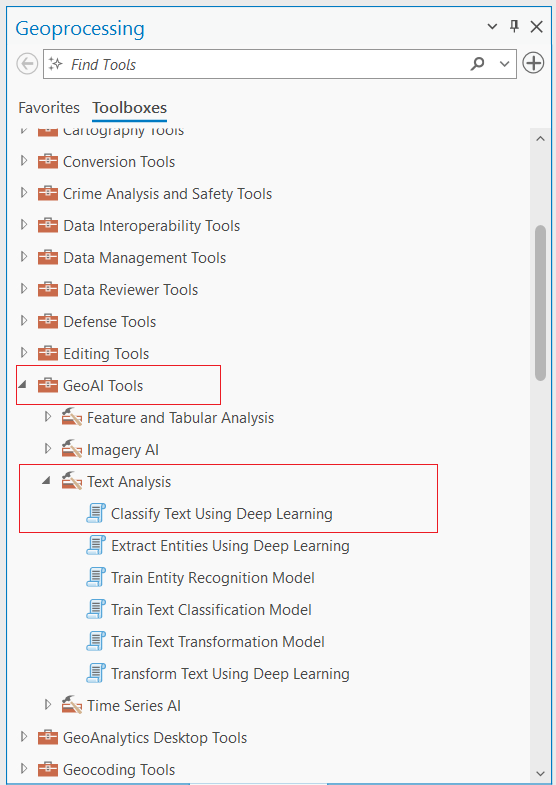

2. **Load Your Custom Model**:
   In the tool's interface, locate the **Input Model Definition File** parameter and load your custom `.dlpk` model file. For example, if your model file is named `MyTextClassifier.dlpk`, select it. 


Complete the other mandatory parameters as needed. For further details, refer to the [official documentation](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/classify-text-using-deep-learning.htm).


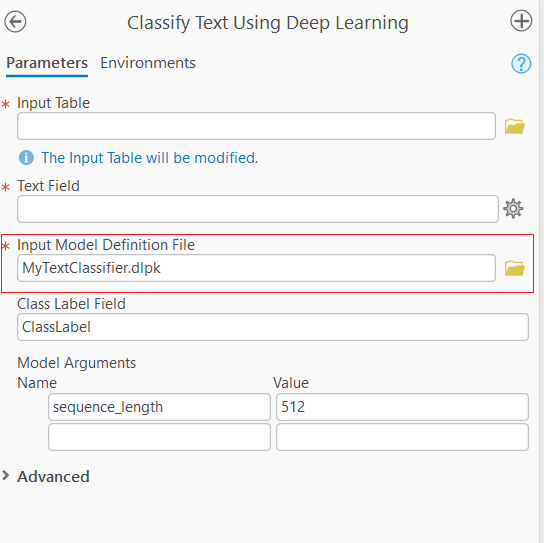

3. **Configure Model Arguments**:
   **Model Arguments** will have the parameters you have defined in the `getParameterInfo()` method of your model. Update these parameters as needed for your model to function correctly. In the example I have given `class_names` and `prompt` parameters.


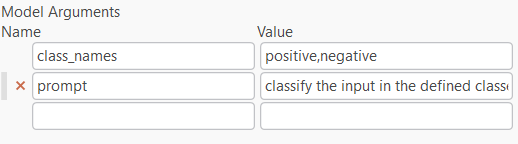

4. **Execute the Tool**:
   After filling in all required parameters, click the **Run** button. This will process the input data and add a new column with the predictions to your input table.


By following these steps, you can effectively use the **Classify Text Using Deep Learning** tool with your custom model in ArcGIS Pro.

## Conclusion
arcgis.learn API and ArcGIS Pro's Text Analysis Toolset, part of the GeoAI Toolbox, enables model extensibility, allowing users to use custom Natural Language Processing (NLP) models into its text analysis workflows. This documentation provides a comprehensive guide on how to create, use custom .dlpk files with these tools and API.